# NLP for Health and Social Care 2018
## Skills Development Workshop
-----------------------------------------


### Table of Contents 
> **Data Preperation**
> - A Brief note about Python packages 
> - Data - document acquisition 
> - Convert pdf document to machine readable text data 
> - Create dataframe from multiple documents converted to text 
> - Split converted text data into columns and create dataframe 

> **Introduction to Natural Language Processing (NLP)**
> - NLP terminology
> - Noise removal
> - Regular expressions
> - N-Grams as features
> - Stemming
> - Lemmatization
> - Tokenising
> - Object standarisation
> - Text to features

> **Data Analysis**
> - Bag of Words model
> - Term Frequency (TF) and Inverse Term Frequency (ITF)
> - Topic Modelling

> **Advanced NLP methods**
> - Text similarity
> - Fuzzy matching
> - Text classification
> - Document clustering
> - Latent Dirichlet Allocation (LDA)
> - Word Embedding




---
### A brief note about Python packages

This code has been developed using Python 3 with Jupyter Notebooks, within an Anaconda Environment. 
Some packages will need to be installed to run the code within this notebook. Instructions will be given in the section where the library is required and `syntax for installation` from a terminal/shell window are provided. 
This notebook does not attempt to explain the Python pacakages in full, further reading is suggested for more information about the packages used in these examples. Links are provided for suggested sources.

---
### Data - document acquisition

Before we can do anything we need data!

In this workshop we are going to work with care home inspection reports published by the Care Quality Commission, these reports are available online: 
http://www.cqc.org.uk/search/services/care-homes?sort=default&distance=15&mode=html&f%5B0%5D=bundle%3Alocation&f%5B1%5D=im_field_care_homes%3A3618&f%5B2%5D=im_field_status%3A3681&f%5B3%5D=im_field_status%3A3683

The data that we are interested in are available online as pdf documents, which is typical for published reports.

We've manually stored a sample of pdf's in the repo: https://github.com/nlpforhealthcare18/nlpforhealthcare18.github.io/tree/master/data
the links for the source of these files can be found in the repository issues. 

We have not included a function for webscraping pdfs's in this notebook, this is something that could be added to enable automatic collection of large numbers of documents. (tip: scrape documents into file structure as in repo to enable seemless integration with the code below) 

---
### Convert pdf document to machine readable text data

let's start off by importing a single pdf file - Victoria_Lodge_Care_Home.pdf - and convert into a text file

to this we make use of pdfminer3k libraries (here for more info https://github.com/jaepil/pdfminer3k )
(if using for the first time you will need to load into anaconda using conda install syntax below in a terminal window)


install pdfminer3k if using for first time (paste syntax below in Terminal window)

```
conda install -c conda-forge pdfminer3k Python libraries

pip install pdfminer.six
```

this code creates a function called **convert**, which can be called with the file path for the pdf file

In [2]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

# create a function to read a pdf document and conver to text, returns text

def convert(fname, pages=None):
# cant get pages func to run...

    if not pages:
        pagenums = set()
    else:
        pagenums = set(pages)

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)

    infile = open(fname, 'rb')
    
    for page in PDFPage.get_pages(infile, pagenums):
        interpreter.process_page(page)
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    
    return text 

# create an object using the converted text, use the file path for the data
text_file = convert('Data/outstanding_reports/Victoria_Lodge_Care_Home.pdf')

print(text_file)

Miss S G Howard
Victoria Lodge Care Home

Date of inspection visit:
26 January 2017

Date of publication:
22 March 2017

Outstanding   

Good     

Good     

Outstanding     

Good     

Outstanding     

Inspection report

11 Victoria Road
Acocks Green
Birmingham
West Midlands
B27 7XZ

Tel: 01217077921
Website: www.victoria-lodge.co.uk

Ratings

Overall rating for this service

Is the service safe?

Is the service effective?

Is the service caring?

Is the service responsive?

Is the service well-led?

1 Victoria Lodge Care Home Inspection report 22 March 2017

Summary of findings

Overall summary

This unannounced inspection took place on the 26 January 2017.  At the last inspection on 1 April 2015, no 
regulations had been breached and the service was rated good overall but there was some improvement 
required in certain aspects of the service.  At this inspection we found that improvements had been made. 

Victoria Lodge Care Home is a residential care home which provides accommo

---
### Create dataframe from multiple documents converted to text 

the **convert** function is applied to multiple files using a *for loop* to read through all the files within the data folder structure. 

(note: the wildcard character * is used to search all folders with names ending "reports" and all documents within those folders with file names ending "pdf")

In [3]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import re

files = glob.glob("Data/*reports/*.pdf")

records = []

for i in files:

    #open the file
    text_file = convert(i)

    # read and process text
    text = text_file.replace("\n", " ")

#     # lets remove the classes from the text in case they are infliuencing the tests
#     to_remove = ['good', 'outstanding', 'inadequate', 'improve']

#     for term in to_remove:
#         text = text.replace(term, ' ')

    text = re.sub('[^a-zA-Z]+', ' ', text)
    # make it all lower case
    text = text.lower()

    # append to our list of reports
    records.append(text)

#convert to dataframe
df = pd.DataFrame(records)

#write train and test data
df.to_csv("Data/full_text.txt", header = None, index= False, quotechar=" ")

# print the head to show a couple of rows
print(df.head())


                                                   0
0  miss s g howard victoria lodge care home date ...
1  healthcare homes lsc limited sandown park care...
2  the cedars baildon limited the cedars inspecti...
3  valeo limited the lodge inspection report scar...
4  summerfield private residential home limited s...


---
### Split converted text data into columns and create dataframe 

this code uses the **convert** function (see above) and creates text strings from each pdf document in the data folder.

the text files are *split* based on sections within the document matching the strings contained within the list **sections**

it also splits the file paths for pdf document, structured according to inspection rating

the split text is entered as columns, along with the inspection rating, for each pdf document (1 row per pdf)

it outputs a dataframe (**df**) within columns named with the items in **sections** (plus additional column names for initial column for the inspection status and the leading text associated with each report)

In [3]:
import nltk
import re
import pprint
from nltk import word_tokenize
import pandas as pd
import glob

files = glob.glob("Data/*reports/*.pdf")

# classes = ['outstanding','good','requires_improvement','inadequate']

sections = ['Date of inspection visit:',
            'Date of publication:',
            'Inspection report',
            'Summary of findings',
            'Is the service safe?',
            'Is the service effective?',
            'Is the service caring?',
            'Is the service responsive?',
            'Is the service well-led?',
            'Detailed findings',
            'Is the service safe?',
            'Our findings',
            'Is the service effective?',
            'Our findings',
            'Is the service caring?',
            'Our findings',
            'Is the service responsive?',
            'Our findings',
            'Is the service well-led?',
            'Our findings']

records = []

# for all the files
for i in files:

    #split the file path/name to get the class names as defined in the class list above
    a,b = i.split("Data/")
    c,d = b.split("_reports")

    #open the file
    text_file = convert(i)

    # read and process text
    text = text_file.replace ('\n', ' ')

    #empty list to contain the sections of each file
    split_text = []
    counter = 0
    split_text.append(c)
    
    # split text by each of the items in the section list defined above
    for j in range(0,len(sections)):
        split_text.append(text.split(sections[j],1)[0])
        counter =+ 1
        text = text.split(sections[j],1)[-1]

    #append the split string to the split list
    split_text.append(text.split(sections[j],1)[-1])

    #append the split list to records (where a record contains a list of section texts for a report. )
    records.append(split_text)

#print(records[1][6])
#turn this list of lists into a dataframe /, columns=list(sections)
cols = ['report status'] + ['intro text'] + sections
df = pd.DataFrame(records, columns=list(cols))
print(df.head())

# print out to tsv (tab seperated) for use elsewhere
df.to_csv("Data/structured_data.csv", header=True, sep="\t")
dfhead = df.head(20)
dfhead.to_csv("Data/structured_data_head.csv", header=True, sep="\t")

  report status                                         intro text  \
0   outstanding  Embrace (Geffen) Limited Nunthorpe Oaks  Inspe...   
1   outstanding  Insight Specialist Behavioural Service Ltd Asp...   
2   outstanding         Miss S G Howard Victoria Lodge Care Home     
3   outstanding  Hale Place Care Homes Limited Hale Place Farmh...   
4   outstanding  Healthcare Homes (LSC) Limited Sandown Park Ca...   

                Date of inspection visit:  \
0        21 February 2017 07 March 2017     
1                      04 December 2017     
2                       26 January 2017     
3   04 September 2017 07 September 2017     
4       09 January 2018 10 January 2018     

                                Date of publication:  \
0   24 May 2017  Outstanding     Good       Good ...   
1   09 February 2018  Outstanding     Good       ...   
2   22 March 2017  Outstanding     Good       Goo...   
3   10 November 2017  Outstanding     Good       ...   
4   27 February 2018  Outsta

---
## Introduction to Natural Language Processing (NLP) 

now that we have our pdf files converted into text and saved as a dataframe, we can use NLP techniques to prepare the data

these are some basic NLP functions that will help us....

| NLP methods |
| ----------------- |
| Stemming          |
| Lemmatisation |
| Word Embeddings |
| Part-of-Speech Tagging |
| Named Entity Disambiguation |
| Named Entity Recognition |
| Sentiment Analysis |
| Semantic Text Similarity |
| Language Identification |
| Text Summarisation |

---
### NLP Terminology

here's some defintions of words we'll be seeing a lot of in NLP:

> *Tokenization* – process of converting a text into tokens

> *Tokens* – words or entities present in the text

> *Text object* – a sentence or a phrase or a word or an article



In [5]:
import nltk 

# nltk.download()

### prompts for user to select corpora to install - indicate which are required

---
### Noise Removal

Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise.

For example:
- language stopwords (commonly used words of a language – is, am, the, of, in etc), 
- URLs or links, social media entities (mentions, hashtags), 
- punctuations and industry specific words. 

This step deals with removal of all types of noisy entities present in the text.

A general approach for noise removal is to prepare a dictionary of noisy entities, and iterate the text object by tokens (or by words), eliminating those tokens which are present in the noise dictionary.

In [6]:
noise_list = ["is", "a", "this", "..."] 

def _remove_noise(input_text):
    words = input_text.split() 
    noise_free_words = [word for word in words if word not in noise_list] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

_remove_noise("this is a at the ... sample text")

'at the sample text'

##### StopWords are words which do not contain important significance to be used in text mining.

In [7]:
from nltk.corpus import stopwords

#Usually these stopwords are filtered out because they return vast amount of unnecessary information
stopWords = set(stopwords.words('english'))


##### sometimes we dont need punctuation.

In [8]:
import string

#set of punctuation characters
pn = set(string.punctuation + '—')

#function to remove punctuation characters

def unpunkt(input):
    output = ''.join(ch for ch in input if ch not in pn)
    return output


#lets test it.


punkttext= '''It is easy to get our hands on millions !!! of words of #text . What can we do with it? '''
unpunkt(punkttext)

'It is easy to get our hands on millions  of words of text  What can we do with it '

In [9]:
unpunkt(text_file)

'F M S Scunthorpe Limited\nAmber House\n\nInspection report\n\n12 Scawby Road\nBroughton\nBrigg\nLincolnshire\nDN20 0AF\n\nTel 01652657349\n\nRatings\n\nDate of inspection visit\n17 August 2017\n18 August 2017\n\nDate of publication\n14 November 2017\n\nOverall rating for this service\n\nInadequate  \n\nIs the service safe\n\nIs the service effective\n\nIs the service caring\n\nIs the service responsive\n\nIs the service wellled\n\nInadequate     \n\nRequires Improvement     \n\nRequires Improvement     \n\nRequires Improvement     \n\nInadequate     \n\n1 Amber House Inspection report 14 November 2017\n\n\x0cSummary of findings\n\nOverall summary\n\nAmber House is registered with the Care Quality Commission CQC to provide accommodation and \npersonal care for a maximum of 13 people It is situated in the village of Broughton close to local amenities\n\nAccommodation is provided over two floors in single bedrooms with en suite facilities There is a large \nsitting room set out into two 

### Regular expressions
Regular expressions (called REs, or regexes, or regex patterns) are essentially a tiny, 
highly specialized programming language embedded inside Python and made available through the re module.
Using this little language, you specify the rules for the set of possible strings that you want to match; 
this set might contain English sentences, or e-mail addresses, or TeX commands, or anything you like. 
You can then ask questions such as:
“Does this string match the pattern?”, or “Is there a match for the pattern anywhere in this string?”. 
You can also use REs to modify a string or to split it apart in various ways.


In [14]:
# Sample code to remove a regex pattern 
import re


def _remove_regex(input_text, regex_pattern):
    urls = re.finditer(regex_pattern, input_text) 
    for i in urls: 
        input_text = re.sub(i.group().strip(), '', input_text)
    return input_text

regex_pattern = "#[\w]*" 

_remove_regex("remove this #hashtag from this website", regex_pattern)

'remove this  from this website'

#Using this little language, you specify the rules for the set of possible strings that you want to match;

In [15]:
htmltext ='''   <div class="container">
      <h3 class="quotes__subtitle chapeau-title chapeau-title--primary">Testimonials</h3>
      <h2 class="u-text-center">Don’t just take our word for it.</h2>
    <div class="quotes__wrapper js-quotes-height">
      <div class="js-quote" data-index="0" style="">
        <div class="quotes__quote">The courses are excellent—they meet a higher standard than other platforms.</div>
        <div class="quotes__description">Helge is a PhD. Candidate in sociology and is learning data science tools to augment his research.</div>
      </div>
      <div class="js-quote" data-index="1" style="display: none;">
        <div class="quotes__quote">Every month I learn something new on DataCamp, and they are all things that are very useful in my job.</div>
        <div class="quotes__description">Godefroy Clair is a Data Scientist at Flylab, where he helps create software for autonomous drones.</div>
      </div>
      <div class="js-quote" data-index="2" style="display: none;">
        <div class="quotes__quote">DataCamp was essential for getting my job, which was my break into data science.</div>
        <div class="quotes__description">Jamen Long used the skills he learned at DataCamp to land a full time job as a data scientist.</div>
      </div>
      <div class="js-quote" data-index="3" style="display: none;">
        <div class="quotes__quote">Data science is the future, and it is better to be on the cutting edge than left behind.</div>
        <div class="quotes__description">Arnaud uses techniques he&#39;s learned on DataCamp every day in his work for the French government.</div>
      </div>
      <div class="js-quote" data-index="4" style="display: none;">
        <div class="quotes__quote">If anything, I regret I didn&#39;t start with DataCamp earlier.</div>
        <div class="quotes__description">Brigham Young University uses DataCamp to help students grasp data science concepts.</div>
      </div>
    </div>
    '''


# i want to find all the strings that:
# start either with capital or lower d then include 'ata' then have space and then they consist of a word
# i describe this pattern as follows:
re.findall(r'[dD]ata [A-Za-z]+',htmltext)

['data science',
 'Data Scientist',
 'data science',
 'data scientist',
 'Data science',
 'data science']

In [16]:
#You can also use Regular expressions to modify a string
def preprocesshtml(text):
    # convert to ASCII

    # if the input is HTML, force-add full stops after these tags
    fullStopTags = ['li', 'p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'dd']
    for tag in fullStopTags:
        text = re.sub(r'</'+tag+'>', '.', text)
    text = re.sub(r'<[^>]+>', '', text)                  # strip out HTML
    text = re.sub(r'[,:;()\-]', ' ', text)               # replace commas, hyphens etc (count as spaces)
    text = re.sub(r'[\.!?]', '.', text)                  # unify terminators
    text = re.sub(r'^\s+', '', text)                     # strip leading whitespace
    text = re.sub(r'[ ]*(\n|\r\n|\r)[ ]*', ' ', text)    # replace new lines with spaces
    text = re.sub(r'([\.])[\. ]+', '.', text)            # check for duplicated terminators
    text = re.sub(r'[ ]*([\.])', '. ', text)             # pad sentence terminators
    text = re.sub(r'\s+', ' ', text)                     # remove multiple spaces
    text = re.sub(r'\s+$', '', text);                    # strip trailing whitespace
    return text




In [17]:
htmltext ='''   <div class="container">
      <h3 class="quotes__subtitle chapeau-title chapeau-title--primary">Testimonials</h3>
      <h2 class="u-text-center">Don’t just take our word for it.</h2>
    <div class="quotes__wrapper js-quotes-height">
      <div class="js-quote" data-index="0" style="">
        <div class="quotes__quote">The courses are excellent—they meet a higher standard than other platforms.</div>
        <div class="quotes__description">Helge is a PhD. Candidate in sociology and is learning data science tools to augment his research.</div>
      </div>
      <div class="js-quote" data-index="1" style="display: none;">
        <div class="quotes__quote">Every month I learn something new on DataCamp, and they are all things that are very useful in my job.</div>
        <div class="quotes__description">Godefroy Clair is a Data Scientist at Flylab, where he helps create software for autonomous drones.</div>
      </div>
      <div class="js-quote" data-index="2" style="display: none;">
        <div class="quotes__quote">DataCamp was essential for getting my job, which was my break into data science.</div>
        <div class="quotes__description">Jamen Long used the skills he learned at DataCamp to land a full time job as a data scientist.</div>
      </div>
      <div class="js-quote" data-index="3" style="display: none;">
        <div class="quotes__quote">Data science is the future, and it is better to be on the cutting edge than left behind.</div>
        <div class="quotes__description">Arnaud uses techniques he&#39;s learned on DataCamp every day in his work for the French government.</div>
      </div>
      <div class="js-quote" data-index="4" style="display: none;">
        <div class="quotes__quote">If anything, I regret I didn&#39;t start with DataCamp earlier.</div>
        <div class="quotes__description">Brigham Young University uses DataCamp to help students grasp data science concepts.</div>
      </div>
    </div>
    '''

In [18]:
preprocesshtml(htmltext)

'Testimonials. Don’t just take our word for it. The courses are excellent—they meet a higher standard than other platforms. Helge is a PhD. Candidate in sociology and is learning data science tools to augment his research. Every month I learn something new on DataCamp and they are all things that are very useful in my job. Godefroy Clair is a Data Scientist at Flylab where he helps create software for autonomous drones. DataCamp was essential for getting my job which was my break into data science. Jamen Long used the skills he learned at DataCamp to land a full time job as a data scientist. Data science is the future and it is better to be on the cutting edge than left behind. Arnaud uses techniques he&#39 s learned on DataCamp every day in his work for the French government. If anything I regret I didn&#39 t start with DataCamp earlier. Brigham Young University uses DataCamp to help students grasp data science concepts.'

In [19]:
unpunkt(preprocesshtml(htmltext))

'Testimonials Don’t just take our word for it The courses are excellentthey meet a higher standard than other platforms Helge is a PhD Candidate in sociology and is learning data science tools to augment his research Every month I learn something new on DataCamp and they are all things that are very useful in my job Godefroy Clair is a Data Scientist at Flylab where he helps create software for autonomous drones DataCamp was essential for getting my job which was my break into data science Jamen Long used the skills he learned at DataCamp to land a full time job as a data scientist Data science is the future and it is better to be on the cutting edge than left behind Arnaud uses techniques he39 s learned on DataCamp every day in his work for the French government If anything I regret I didn39 t start with DataCamp earlier Brigham Young University uses DataCamp to help students grasp data science concepts'

### N-Grams as Features

In [10]:

def generate_ngrams(text, n):
    words = text.split()
    output = []  
    for i in range(len(words)-n+1):
        output.append(words[i:i+n])
    return output

# Binary gram 
generate_ngrams('this is a sample text', 2)

[['this', 'is'], ['is', 'a'], ['a', 'sample'], ['sample', 'text']]

In [11]:
from nltk import bigrams, trigrams
from nltk import word_tokenize

sent = word_tokenize("The quick brown fox jumps over the lazy dog")
sent_bigrams = bigrams(sent)
sent_trigrams = trigrams(sent)

In [12]:
list(sent_bigrams)

[('The', 'quick'),
 ('quick', 'brown'),
 ('brown', 'fox'),
 ('fox', 'jumps'),
 ('jumps', 'over'),
 ('over', 'the'),
 ('the', 'lazy'),
 ('lazy', 'dog')]

In [13]:
list(sent_trigrams)

[('The', 'quick', 'brown'),
 ('quick', 'brown', 'fox'),
 ('brown', 'fox', 'jumps'),
 ('fox', 'jumps', 'over'),
 ('jumps', 'over', 'the'),
 ('over', 'the', 'lazy'),
 ('the', 'lazy', 'dog')]

---
### Lexicon Normalization


Normalization is a pivotal step for feature engineering with text as it converts the high dimensional features (N different features) to the low dimensional space (1 feature), which is an ideal ask for any ML model.

---
### Stemming

Stemming is a rudimentary rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.

In [20]:
from nltk.stem.porter import PorterStemmer 

# Defining objects
stem = PorterStemmer()

word_1 = "multiplying" 
word_2 = "integrating"

print(stem.stem(word_1))
print(stem.stem(word_2))

multipli
integr


---
### Lemmatization

Lemmatization, on the other hand, is an organized & step by step procedure of obtaining the root form of the word, it makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [21]:
from nltk import WordNetLemmatizer

# Defining objects 
lem = WordNetLemmatizer()

word_1 = "multiplying" 
word_2 = "integrating"

print(lem.lemmatize(word_1, "v"))
print(lem.lemmatize(word_2, "v"))

multiply
integrate


--- 
### Tokenise

When we sent_tokenize a string we produce a list (of sentences).

Then from that we can word_tokenize a list of words

In [4]:
import pandas as pd
from operator import itemgetter
import string
import numpy as np
from collections import Counter

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords 

from nltk.corpus import wordnet


wordnet_lemmatizer = WordNetLemmatizer()

def tokenize(document):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation (breaking into sentences), then word/punctuation
        tokenization, and finally part of speech tagging. It uses the part of
        speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        tokens=[]
        
        
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):


                # If  stopword, ignore token and continue otherwise provide lemma
                if token in stopWords:
                    continue
                else:
                    tokens.append(wordnet_lemmatizer.lemmatize(token).lower())
                
            
        return tokens



/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:
text='''     WordNet is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped 
into sets of cognitive synonyms (synsets), each expressing a distinct concept. 
Synsets are interlinked by means of conceptual-semantic and lexical relations. 
The resulting network of meaningfully related words and concepts can be navigated with the browser. 
WordNet is also freely and publicly available for download. WordNet’s structure makes it 
 a useful tool for computational linguistics and natural language processing.

WordNet superficially resembles a thesaurus, in that it groups words together based on their meanings. 
However, there are some important distinctions. First, WordNet interlinks not just word forms—strings 
of letters—but specific senses of words. As a result, words that are found in close proximity to one 
another in the network are semantically disambiguated. Second, WordNet labels the semantic 
relations among words, whereas the groupings of words in a thesaurus does not 
follow any explicit pattern other than meaning similarity '''



(tokenize(unpunkt(text)))

['wordnet',
 'large',
 'lexical',
 'database',
 'english',
 'nouns',
 'verb',
 'adjective',
 'adverb',
 'grouped',
 'set',
 'cognitive',
 'synonym',
 'synset',
 'expressing',
 'distinct',
 'concept',
 'synsets',
 'interlinked',
 'mean',
 'conceptualsemantic',
 'lexical',
 'relation',
 'the',
 'resulting',
 'network',
 'meaningfully',
 'related',
 'word',
 'concept',
 'navigated',
 'browser',
 'wordnet',
 'also',
 'freely',
 'publicly',
 'available',
 'download',
 'wordnet',
 '’',
 'structure',
 'make',
 'useful',
 'tool',
 'computational',
 'linguistics',
 'natural',
 'language',
 'processing',
 'wordnet',
 'superficially',
 'resembles',
 'thesaurus',
 'group',
 'word',
 'together',
 'based',
 'meaning',
 'however',
 'important',
 'distinction',
 'first',
 'wordnet',
 'interlinks',
 'word',
 'formsstrings',
 'lettersbut',
 'specific',
 'sens',
 'word',
 'as',
 'result',
 'word',
 'found',
 'close',
 'proximity',
 'one',
 'another',
 'network',
 'semantically',
 'disambiguated',
 'secon

In [24]:
tokenize(unpunkt(preprocesshtml(htmltext)))

['testimonials',
 'don',
 '’',
 'take',
 'word',
 'the',
 'course',
 'excellentthey',
 'meet',
 'higher',
 'standard',
 'platform',
 'helge',
 'phd',
 'candidate',
 'sociology',
 'learning',
 'data',
 'science',
 'tool',
 'augment',
 'research',
 'every',
 'month',
 'i',
 'learn',
 'something',
 'new',
 'datacamp',
 'thing',
 'useful',
 'job',
 'godefroy',
 'clair',
 'data',
 'scientist',
 'flylab',
 'help',
 'create',
 'software',
 'autonomous',
 'drone',
 'datacamp',
 'essential',
 'getting',
 'job',
 'break',
 'data',
 'science',
 'jamen',
 'long',
 'used',
 'skill',
 'learned',
 'datacamp',
 'land',
 'full',
 'time',
 'job',
 'data',
 'scientist',
 'data',
 'science',
 'future',
 'better',
 'cutting',
 'edge',
 'left',
 'behind',
 'arnaud',
 'us',
 'technique',
 'he39',
 'learned',
 'datacamp',
 'every',
 'day',
 'work',
 'french',
 'government',
 'if',
 'anything',
 'i',
 'regret',
 'i',
 'didn39',
 'start',
 'datacamp',
 'earlier',
 'brigham',
 'young',
 'university',
 'us',
 'da

we can tokenise strings in dataframe using df.apply




In [34]:
import pandas as pd
import nltk


df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row[5]), axis=1)
print(df['tokenized_sents'].head())

0    [The, service, was, effective, ., There, were,...
1    [The, service, was, effective, ., People, 's, ...
2    [The, service, was, not, consistently, effecti...
3    [The, service, was, not, always, effective, .,...
4    [The, service, was, effective, ., People, rece...
Name: tokenized_sents, dtype: object


In [44]:
import pandas as pd
import nltk


# df1 = df.apply(lambda x: x[0].lower(), axis=1)
# print(df1.head())


# columns = [0,21]
for column in range(0,21) :
    df1[column] = df[column].apply(lambda x: x.lower()).copy()
    
print(df1.head())

df1

0    0             outstanding
1             outsta...
1    0    miss s g howard victoria lodge care home ...
2    0      is the service safe?  is the service ef...
3    0      this unannounced inspection took place ...
4    0      the service was safe  people told us th...
dtype: object


0     0             outstanding
1             outsta...
1     0    miss s g howard victoria lodge care home ...
2     0      is the service safe?  is the service ef...
3     0      this unannounced inspection took place ...
4     0      the service was safe  people told us th...
5     0      the service was effective.   there were...
6     0      the service was very caring.  people re...
7     0      the service was extremely responsive.  ...
8     0      the service was very well led.  people ...
9     0     we carried out this inspection under sec...
10    0                      good  
1               ...
11    0       people and relatives all gave us very ...
12    0                      good  
1               ...
13    0       people and relatives we spoke with tol...
14    0               outstanding  
1               ...
15    0       people living in victoria lodge were h...
16    0                      good  
1               ...
17    0       relatives told us that the support

---
### Object Standardization

In [49]:
text_raw ="This is a rt retweeted tweet by me and its awsm"

lookup_dict = {'rt':'Retweet', 'dm':'direct message', "awsm" : "awesome", "luv" :"love"}

def _lookup_words(input_text):
    words = input_text.split() 
    new_words = [] 
    for word in words:
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]
        new_words.append(word) 
        new_text = " ".join(new_words) 
    return new_text

_lookup_words(text_raw)

'This is a Retweet retweeted tweet by me and its awesome'

---
### Text to Features


##### Syntactic Parsing

In [52]:
from nltk import word_tokenize, pos_tag

text = "I am learning Natural Language Processing on Analytics Vidhya"
tokens = word_tokenize(text)

print(pos_tag(tokens))

## Proper Noun:
#NNP (Proper Noun)
# VBG Verb gerund 

setence_1 = "Please book my flight for Delhi"

setence_2 = "I am going to read this book in the flight"


# Context based ?

pos_tag(word_tokenize(setence_2))

pos_tag(word_tokenize(setence_1))

[('I', 'PRP'), ('am', 'VBP'), ('learning', 'VBG'), ('Natural', 'NNP'), ('Language', 'NNP'), ('Processing', 'NNP'), ('on', 'IN'), ('Analytics', 'NNP'), ('Vidhya', 'NNP')]


[('Please', 'NNP'),
 ('book', 'NN'),
 ('my', 'PRP$'),
 ('flight', 'NN'),
 ('for', 'IN'),
 ('Delhi', 'NNP')]

#### The process of detecting the named entities such as person names, location names, company names etc from the text is called as NER.

---
## Data Analysis

Now that we have cleaned our text and formatted the data structure, we can carry out some analysis - *yipee!*



---
### Bag-of-Words Model

We cannot work with text directly when using machine learning algorithms.

Instead, we need to convert the text to numbers.

We may want to perform classification of documents, so each document is an “input” and a class label is the “output” for our predictive algorithm. Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers.

A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW.


In [68]:
import pandas as pd

#dr seuss quotes!!! some examples of text

text = [ 
    
        'the cat with the hat sat in the mat',
        'you have brains in your head ',' you have feet in your shoes',
        'You can steer yourself any direction you choose' ,
        'Think and wonder, wonder and think', 'The more that you read',' the more things you will know',
        'The more that you learn' ,'the more places you’ll go',
        'the mat has a cat with a hat']

#from list into a pandas dataframe
txt = pd.DataFrame(text,columns=['text'])

txt

,text
0,the cat with the hat sat in the mat
1,you have brains in your head
2,you have feet in your shoes
3,You can steer yourself any direction you choose
4,"Think and wonder, wonder and think"
5,The more that you read
6,the more things you will know
7,The more that you learn
8,the more places you’ll go
9,the mat has a cat with a hat


#### Counts/Occurrences

The model is simple in that it throws away all of the order information in the words and focuses on the occurrence of words in a document.



In [70]:

from sklearn.feature_extraction.text import CountVectorizer


count_vect = CountVectorizer()
X_transformed = count_vect.fit_transform(txt.text.values)


# by using .A we show the sparse matrix as an numpy array
X_transformed.A


#This is the format machine learning algorithms understand from text data!

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

#### But this is goobledygook ! what does it REALLY MEAN?

in order to understand what is happening we  create a dataframe from the matrix above to elucidate the Countvectorizer process. We append a new column with the feature names with .get_feature_names() to make it even more clear.

In [71]:
vectdf =pd.DataFrame(X_transformed.A.T)
vectdf['term']=count_vect.get_feature_names()

#rows are words. each column represents a document. This is the DTM *document term matrix*
vectdf

,0,1,2,3,4,5,6,7,8,9,term
0,0,0,0,0,2,0,0,0,0,0,and
1,0,0,0,1,0,0,0,0,0,0,any
2,0,1,0,0,0,0,0,0,0,0,brains
3,0,0,0,1,0,0,0,0,0,0,can
4,1,0,0,0,0,0,0,0,0,1,cat
5,0,0,0,1,0,0,0,0,0,0,choose
6,0,0,0,1,0,0,0,0,0,0,direction
7,0,0,1,0,0,0,0,0,0,0,feet
8,0,0,0,0,0,0,0,0,1,0,go
9,0,0,0,0,0,0,0,0,0,1,has


In [72]:
#Show the words and the its numerical index
count_vect.vocabulary_

{'and': 0,
 'any': 1,
 'brains': 2,
 'can': 3,
 'cat': 4,
 'choose': 5,
 'direction': 6,
 'feet': 7,
 'go': 8,
 'has': 9,
 'hat': 10,
 'have': 11,
 'head': 12,
 'in': 13,
 'know': 14,
 'learn': 15,
 'll': 16,
 'mat': 17,
 'more': 18,
 'places': 19,
 'read': 20,
 'sat': 21,
 'shoes': 22,
 'steer': 23,
 'that': 24,
 'the': 25,
 'things': 26,
 'think': 27,
 'will': 28,
 'with': 29,
 'wonder': 30,
 'you': 31,
 'your': 32,
 'yourself': 33}

#### From occurrences to frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count 
values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

     This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

#### Term Frequency (TF) 

> TF for a term “t” is defined as the count of a term “t” in a document “D”

#### Inverse Document Frequency (IDF) 
> IDF for a term is defined as logarithm of ratio of total documents available in the corpus and number of documents  containing the term T.

In [74]:
tfidf_vect = TfidfVectorizer()
X_tf_transformed = tfidf_vect.fit_transform(txt.text.values)


# this is what a machine learning algorithm needs.


#but for better understanding... lets see what is the DTM. This time its 
#the DTM holds downscaled frequencies as values and not counts.

tfidf_vectdf =pd.DataFrame(X_tf_transformed.A.T)
tfidf_vectdf['term']=tfidf_vect.get_feature_names()
tfidf_vectdf

,0,1,2,3,4,5,6,7,8,9,term
0,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,0.000000,0.000000,0.000000,and
1,0.000000,0.000000,0.000000,0.379309,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,any
2,0.000000,0.485869,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,brains
3,0.000000,0.000000,0.000000,0.379309,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,can
4,0.320449,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.415853,cat
5,0.000000,0.000000,0.000000,0.379309,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,choose
6,0.000000,0.000000,0.000000,0.379309,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,direction
7,0.000000,0.000000,0.485869,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,feet
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.502327,0.000000,go
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.489186,has


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

obj = TfidfVectorizer()
obj = TfidfVectorizer()

corpus = ['This is sample document.', 'another random document.', 'third sample document text']

X = obj.fit_transform(corpus)

print(X)

  (0, 7)	0.5844829010200651
  (0, 2)	0.5844829010200651
  (0, 4)	0.444514311537431
  (0, 1)	0.34520501686496574
  (1, 1)	0.3853716274664007
  (1, 0)	0.652490884512534
  (1, 3)	0.652490884512534
  (2, 4)	0.444514311537431
  (2, 1)	0.34520501686496574
  (2, 6)	0.5844829010200651
  (2, 5)	0.5844829010200651


---
### Topic Modelling 

Topic modeling is a process of automatically identifying the topics present in a text corpus, it derives the hidden patterns among the words in the corpus in an unsupervised manner. 

>Topics are defined as “a repeating pattern of co-occurring terms in a corpus”. 

> A good topic model results in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare, and “farm”, “crops”, “wheat” for a topic – “Farming”.

---
# Advanced NLP tasks




---
### Text Matching / Similarity

#### A. Levenshtein Distance 
The Levenshtein distance between two strings is defined as 

> the minimum number of edits needed to transform one string into the other,
> with the allowable edit operations being insertion, deletion, or substitution of a single character. 

Following is the implementation for efficient memory computations.

In [63]:
def levenshtein(s1,s2): 
    if len(s1) > len(s2):
        s1,s2 = s2,s1 
    distances = range(len(s1) + 1) 
    for index2,char2 in enumerate(s2):
        newDistances = [index2+1]
        for index1,char1 in enumerate(s1):
            if char1 == char2:
                newDistances.append(distances[index1]) 
            else:
                 newDistances.append(1 + min((distances[index1], distances[index1+1], newDistances[-1]))) 
        distances = newDistances 
    return distances[-1]

print(levenshtein("analyze","analyse"))

print(levenshtein("analyze","information"))

1
9


---
### Phonetic Matching 

A Phonetic matching algorithm takes a keyword as input (person’s name, location name etc) and produces a character string that identifies a set of words that are (roughly) phonetically similar. It is very useful for searching large text corpuses, correcting spelling errors and matching relevant names. 

**Soundex** and **Metaphone**
are two main phonetic algorithms used for this purpose. 

Python’s module Fuzzy is used to compute soundex strings for different words, for example –

In [64]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

fuzz.ratio("ACME Factory alpha", "ACME Factory Inc.")
fuzz.partial_ratio("ACME Factory alpha", "ACME Factory Inc.")

ModuleNotFoundError: No module named 'fuzzywuzzy'

In [66]:
import fuzzy

soundex = fuzzy.Soundex(4)

print(soundex('ankita'))
print(soundex('aunkit'))

ModuleNotFoundError: No module named 'fuzzy'

---

### Text Classification


Text classification, in common words is defined as a technique to systematically classify a text object (document or sentence) in one of the fixed category. It is really helpful when the amount of data is too large, especially for organizing, information filtering, and storage purposes.

A typical natural language classifier consists of two parts: *Training* and *Prediction* 

Firstly the text input is processes and features are created. The machine learning models then learn these features and is used for predicting against the new text.

Examples of text classification applications are: Email Spam Identification, topic classification of news, sentiment classification and organization of web pages by search engines.


#### you will need to install textblob

```
pip install -U textblob
```

#### and download the corpora

```
python -m textblob.download_corpora
```

In [60]:
from textblob.classifiers import NaiveBayesClassifier as NBC
from textblob import TextBlob


training_corpus = [ ('I am exhausted of this work.', 'Class_B'),
                   ("I can't cooperate with this", 'Class_B'),
                   ('He is my badest enemy!', 'Class_B'),
                   ('My management is poor.', 'Class_B'),
                   ('I love this burger.', 'Class_A'),
                   ('This is an brilliant place!', 'Class_A'),
                   ('I feel very good about these dates.', 'Class_A'),
                   ('This is my best work.', 'Class_A'),
                   ("What an awesome view", 'Class_A'),
                   ('I do not like this dish', 'Class_B')]

test_corpus = [("I am not feeling well today.", 'Class_B'), 
                ("I feel brilliant!", 'Class_A'), 
                ('Gary is a friend of mine.', 'Class_A'), 
                ("I can't believe I'm doing this.", 'Class_B'), 
                ('The date was good.', 'Class_A'), ('I do not enjoy my job', 'Class_B')]

model = NBC(training_corpus) 

print(model.classify("Their codes are amazing."))
print(model.classify("I don't like their computer."))

print (model.classify(test_corpus[4][0]))
print(model.accuracy(test_corpus))

ModuleNotFoundError: No module named 'textblob'

In [61]:
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import svm

# preparing data for SVM model (using the same training_corpus, test_corpus from naive bayes example)
train_data = []
train_labels = []

for row in training_corpus:
    train_data.append(row[0])
    train_labels.append(row[1])

test_data = [] 
test_labels = []

for row in test_corpus:
    test_data.append(row[0]) 
    test_labels.append(row[1])

# Create feature vectors 
vectorizer = TfidfVectorizer(min_df=4, max_df=0.9)

# Train the feature vectors
train_vectors = vectorizer.fit_transform(train_data)

# Apply model on test data 
test_vectors = vectorizer.transform(test_data)

# Perform classification with SVM, kernel=linear 
model = svm.SVC(kernel='linear') 
model.fit(train_vectors, train_labels) 
prediction = model.predict(test_vectors)


print (classification_report(test_labels, prediction))
 

NameError: name 'training_corpus' is not defined

# Text Classification some basics
``` We will take the loaded data and do some basic text classification on the imported data. The folowing method takes for instance a column specific to particular feature and counts the frequency of words and plots the grouped words in decreasing order of their frequencies. We can make use of techniques like removing stopwords, ngrams, frequency distribution and work tokenize. ```

Text Classification some basics


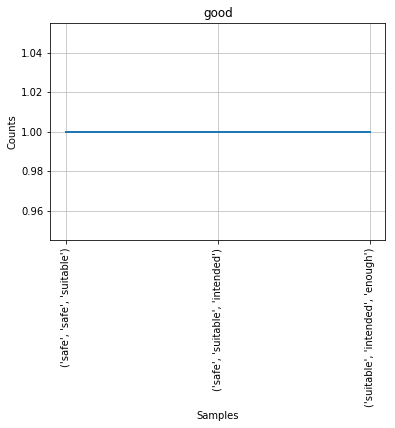

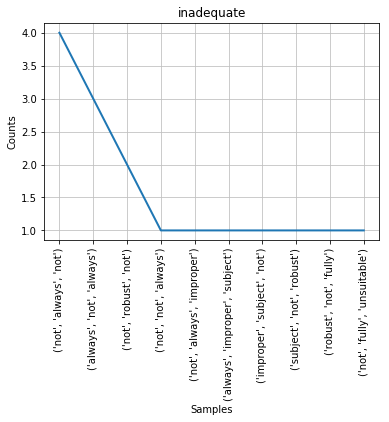

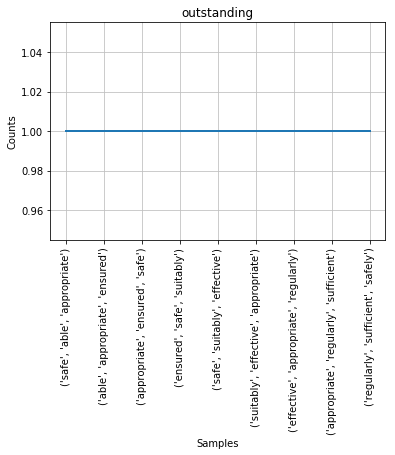

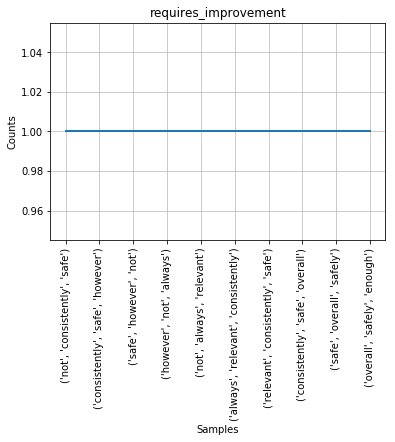

In [2]:
print ("Text Classification some basics")

sep='+'*20
import nltk
from nltk.classify import apply_features

import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

path='data/structured_data.csv'
strctured_df=pd.read_csv(path,error_bad_lines=False,sep='\t')
col_names=list(strctured_df)
del strctured_df[col_names[0]]
strctured_df.head()



# Creating a smaller dataframe to play with a few features.
# Data might be a bit disordered ?
subset_df=strctured_df[['Overall rating for this service','Is the service caring?']]

subset_df_grped=subset_df.groupby('Overall rating for this service')['Is the service caring?'].\
apply(lambda x: "{%s}" % ', '.join(x)).to_frame()
subset_df_grped=subset_df_grped.reset_index()
subset_df_grped


num_rows=subset_df_grped.shape[0]
first_n_common=10
fetr_list=[]
for index in range(num_rows):
    words=[]
    filtered_words=[]
    #text=subset_df['Is the service caring?'][index].lower()
    #tagged_sentence = nltk.tag.pos_tag(text.split())
    text=subset_df_grped['Is the service caring?'][index].lower()
    tagged_sentence = nltk.tag.pos_tag(text.split())
    edited_sentence = [word for word,tag in tagged_sentence 
                       # To only collect adverbs and adjectives... 
                       if tag in ('JJ','RB')]
                       # To remove the Nouns... 
                       #if tag not in ('NN', 'NNP', 'NNPS', 'NNS')]
    #edited_sentence
    # Just ensure the sentence has alphabetical characters 
    words = [word for word in edited_sentence if word.isalpha()]
    
    # We can also remove the stopwords..the, in, to, that...
    #filtered_words = [word for word in words if word not in stopwords.words('english')]
    filtered_words = words
    
    # Change the number of words in a pairs
    fdist = FreqDist(ngrams(filtered_words,3))
    
    most_imp = FreqDist(dict(fdist.most_common()[:first_n_common]))
    fetr_list.append(most_imp)
keys=subset_df_grped['Overall rating for this service'].tolist()
dictionary = dict(zip(keys, fetr_list))
lst_dic=list(dictionary.keys())
for index in range(len(lst_dic)):
    dictionary.get(lst_dic[index]).plot(title=lst_dic[index])

```The following deals with basic feature engineering strategies. This can be used to train a 'classifier'. The following uses a pre-loaded dataset but hopefully similar techniques can be used on an actual dataset''.


In [ ]:
#Source: http://www.nltk.org/book/ch06.html

#Supervised Classification
#Deciding whether an email is spam or not.
#Deciding what the topic of a news article
#is, from a fixed list of topic areas such 
#as "sports," "technology," and "politics."

# in multi-class classification, each instance 
#may be assigned multiple labels; in open-class
#classification, the set of labels is not defined
#in advance; and in sequence classification, a list
#of inputs are jointly classified.
sep='+'*20
import nltk
from nltk.classify import apply_features


#The first step in creating a classifier is
#deciding what features of the input are 
#relevant, and how to encode those features. 
#For this example, we'll start by just looking
#at the final letter of a given name. The following
#feature extractor function builds a dictionary
#containing relevant information about a given name:


# Gender Identification
# a, e and i are likely to be female,
#while names ending in k, o, r, s and t
#are likely to be male.
def gender_features(word):
    return {'last_letter': word[-1]}
gender_features('Shrek')
gender_features('Joshi')
#The returned dictionary, known as a feature set, 
#maps from feature names to their values.


#Now that we've defined a feature extractor, 
#we need to prepare a list of examples and corresponding class labels.
from nltk.corpus import names
labeled_names = ([(name, 'male') for name in names.words('male.txt')] +
                 [(name, 'female') for name in names.words('female.txt')])
##Data preparation

import random
random.shuffle(labeled_names)



#Next, we use the feature extractor to process 
#the names data, and divide the resulting list
#of feature sets into a training set
#and a test set. The training set is used to 
#train a new "naive Bayes" classifier.
import nltk
featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]
# Use a stratification strategy ?
train_set, test_set = featuresets[500:], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (sep)
print("Gender of Jeny is", classifier.classify(gender_features('Jeny')))
print (sep)
print("Gender of Lewis is", classifier.classify(gender_features('Lewis')))
print (sep)
print("Gender prediction accuracy of the classifer is:",nltk.classify.accuracy(classifier, test_set))

classifier.show_most_informative_features(5)


#Modify the gender_features() function to provide
#the classifier with features encoding the length 
#of the name, its first letter, and any other 
#features that seem like they might be
#informative. Retrain the classifier with 
#these new features, and test its accuracy.
def gender_features_v2(word):
    return {'first_letter': word[0],'length_letter': len(word)}
gender_features_v2('Shrek')
gender_features_v2('Joshi')



#Next, we use the feature extractor to process 
#the names data, and divide the resulting list
#of feature sets into a training set
#and a test set. The training set is used to 
#train a new "naive Bayes" classifier.

featuresets = [(gender_features_v2(n), gender) for (n, gender) in labeled_names]
# Use a stratification strategy ?

train_set = apply_features(gender_features_v2, labeled_names[500:])
test_set = apply_features(gender_features_v2, labeled_names[:500])
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (sep)
print("Gender of Jeny is", classifier.classify(gender_features('Jeny')))
print (sep)
print("Gender of William is", classifier.classify(gender_features('William')))
print(sep)
print("Gender prediction accuracy of the classifer is:",nltk.classify.accuracy(classifier, test_set))

classifier.show_most_informative_features(5)


# Over-fitting by choosing too many features ??
def gender_features2(name):
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count({})".format(letter)] = name.lower().count(letter)
        features["has({})".format(letter)] = (letter in name.lower())
    return features

featuresets = [(gender_features2(n), gender) for (n, gender) in labeled_names]
# Use a stratification strategy ?

#train_set = apply_features(gender_features2, labeled_names[500:])
#test_set = apply_features(gender_features2, labeled_names[:500])
train_set, test_set = featuresets[500:], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (sep)
print("Gender of Jeny is", classifier.classify(gender_features('Jeny')))
print (sep)
print("Gender of William is", classifier.classify(gender_features('William')))
print(sep)
print("Gender prediction accuracy of the classifer is:",nltk.classify.accuracy(classifier, test_set))

classifier.show_most_informative_features(10)

---
### Document clustering

we will not have time to go through unsupervised machine learning methods in this workshop

a good source for further information on this subject can be found here:
http://brandonrose.org/clustering



---
### Latent Dirichlet Allocation (LDA)

In [53]:
doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father." 
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."

doc_complete = [doc1, doc2, doc3]
doc_clean = [doc.split() for doc in doc_complete]

doc_clean

[['Sugar',
  'is',
  'bad',
  'to',
  'consume.',
  'My',
  'sister',
  'likes',
  'to',
  'have',
  'sugar,',
  'but',
  'not',
  'my',
  'father.'],
 ['My',
  'father',
  'spends',
  'a',
  'lot',
  'of',
  'time',
  'driving',
  'my',
  'sister',
  'around',
  'to',
  'dance',
  'practice.'],
 ['Doctors',
  'suggest',
  'that',
  'driving',
  'may',
  'cause',
  'increased',
  'stress',
  'and',
  'blood',
  'pressure.']]

#### Gensim

> Gensim is a free Python library designed to automatically extract semantic topics from documents, as efficiently (computer-wise) and painlessly (human-wise) as possible. https://radimrehurek.com/gensim/index.html

In [54]:
import gensim

from gensim import corpora

ModuleNotFoundError: No module named 'gensim'

In [55]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index.  
dictionary = corpora.Dictionary(doc_clean)

#Converting list of documents (corpus) into Document
#Term Matrix using dictionary prepared above. 
## ?? vectors number of times each elements appears
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

print (doc_term_matrix)

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

# Results 
print(ldamodel.print_topics())

NameError: name 'corpora' is not defined

In [56]:
text="He is a big big boy"

doc_clean= [text.split()]
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Running and Training LDA model on the document term matrix
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

# Results 
print(ldamodel.print_topics()[0])

NameError: name 'corpora' is not defined

---
### Word Embedding (text vectors)

#### Word2Vec
#### GloVe 

Word2Vec model is composed of preprocessing module, a shallow neural network model called Continuous Bag of Words and another shallow neural network model called skip-gram. These models are widely used for all other nlp problems. It first constructs a vocabulary from the training corpus and then learns word embedding representations. Following code using gensim package prepares the word embedding as the vector

In [59]:
from gensim.models import Word2Vec

sentences = [['data', 'science'], ['vidhya', 'science', 'data', 'analytics'],
             ['machine', 'learning'], ['deep', 'learning']]


# train the model on your corpus
model = Word2Vec(sentences, min_count = 1)

print(model.similarity('data', 'science'))

print(model['learning']) 

ModuleNotFoundError: No module named 'gensim'